# Extraction and exploration of Cognite OID

In [1]:
# Imports
# %pip install seaborn
from publicdata import client as c
from functions import *
from datetime import datetime, timezone

In [2]:
# Nine sensors related to the inputs, outputs and controls of a compressor subsystem.
# Dictionary made with key=name of sensor and value=Id of sensor
sensors = {
    'PDT-92534':6908033636680653,
    'PT-92523':8877482139815959,
    'TIC-92504':7012228881452176,
    'TT 92532':8152209984966682,
    'FT-92537':3278479880462408,
    'TT-92539':643849686863640,
    'PT-92539':1890487216163163,
    'ZT 92543':4146236330407219,
    'KA 9101':844472910348820
}
# I'll extract a pandas dataframe for each of the sensors in sensor_names, and these will be stored
# in the following dictionary, again with the sensor name as the key.
dfs_dict = {}

startdate = datetime(2018, 11, 5, tzinfo=timezone.utc)
enddate = datetime(2018, 11, 15, tzinfo=timezone.utc)
today = datetime.today()

Sensor name    Frame length   First period length [s]  First timestamp
PDT-92534      (28651, 1)     30.0                     2018-11-05 00:00:00
PT-92523       (28650, 1)     30.0                     2018-11-05 00:00:00
TIC-92504      (28650, 1)     30.0                     2018-11-05 00:00:00
TT 92532       (26149, 1)     30.0                     2018-11-05 00:00:00
FT-92537       (28650, 1)     30.0                     2018-11-05 00:00:00
TT-92539       (26951, 1)     30.0                     2018-11-05 00:00:00
PT-92539       (28650, 1)     30.0                     2018-11-05 00:00:00
ZT 92543       (27733, 1)     30.0                     2018-11-05 00:00:00
KA 9101        (28625, 1)     30.0                     2018-11-05 00:00:00


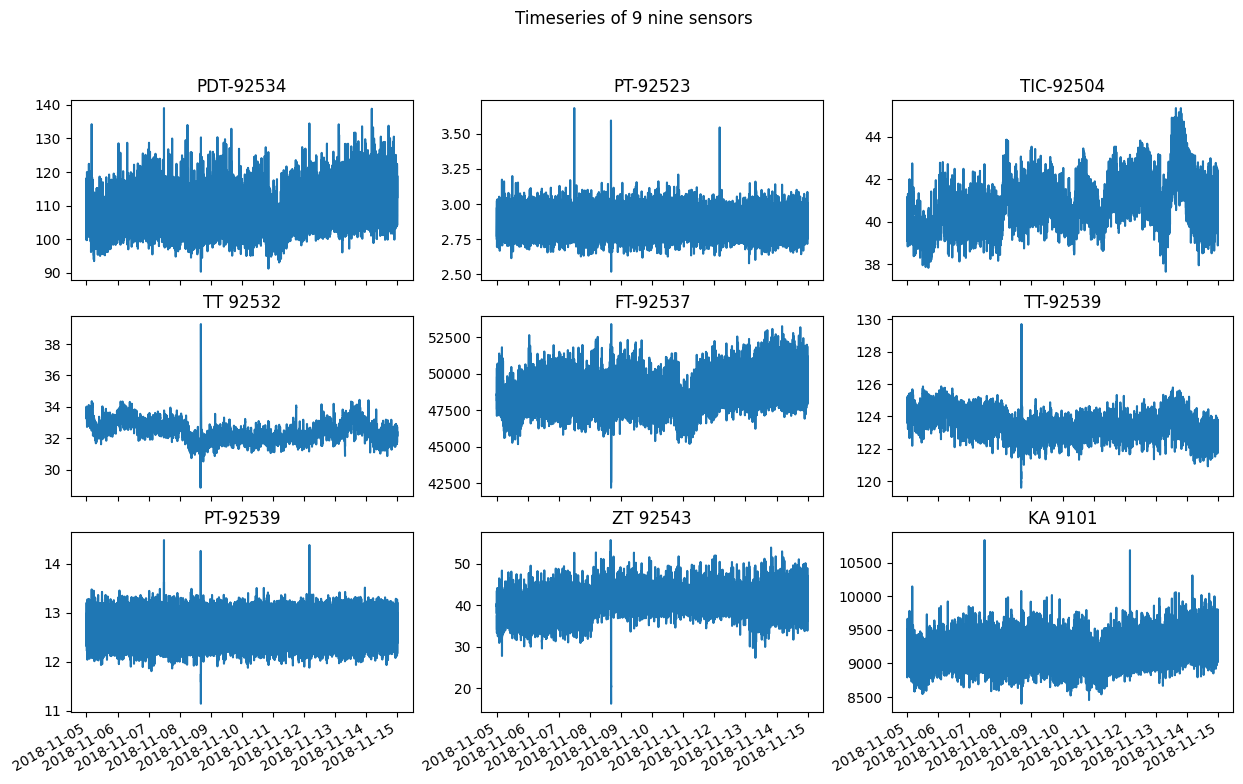

In [3]:

print("Sensor name".ljust(15) + "Frame length".ljust(15) + "First period length [s]".ljust(25) + "First timestamp".ljust(15))

# Extract dataframes from Cognite OID and store them in the dfs_dict dictionary
for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    # Need to find a way to grab the unit of the time-series
    dfs_dict[k] = res
    sr = (res.index[1] - res.index[0]).total_seconds()
    # print(f'{k}\'s shape: {res.shape} and sampling frequency: {sr} second(s)')
    print(str(k).ljust(15) + str(res.shape).ljust(15) + str(sr).ljust(25) + str(res.index[0]).ljust(15))

# plot_sensor_data('PDT-92534', dfs_dict)
plot_all_nine_sensors(dfs_dict)


### Simple inspection of the data

In [4]:
# print((dfs_dict["ZT 92543"].index[1] - dfs_dict["ZT 92543"].index[0]).total_seconds())

print("Name".ljust(12) + "First period".ljust(15) + "Second period".ljust(15) + "Third period".ljust(15) + "Average period".ljust(15))
for name, df in dfs_dict.items():
    f_per = (df.index[1] - df.index[0]).total_seconds()
    second_per = (df.index[2] - df.index[1]).total_seconds()
    third_per = (df.index[3] - df.index[2]).total_seconds()
    avg_per = ((df.index[-1] - df.index[0])/df.shape[0]).total_seconds()
    print(name.ljust(12) + str(f_per).ljust(15) + str(second_per).ljust(15) + str(third_per).ljust(15) + str(avg_per).ljust(15))


Name        First period   Second period  Third period   Average period 
PDT-92534   30.0           30.0           30.0           30.154968      
PT-92523    30.0           30.0           30.0           30.15602       
TIC-92504   30.0           30.0           30.0           30.15602       
TT 92532    30.0           30.0           30.0           33.040269      
FT-92537    30.0           30.0           30.0           30.15602       
TT-92539    30.0           30.0           30.0           32.057066      
PT-92539    30.0           30.0           30.0           30.15602       
ZT 92543    30.0           30.0           30.0           31.153138      
KA 9101     30.0           30.0           30.0           30.182358      


In [5]:
#We see above that the average period is longer than 30 seconds, meaning some datapoints are missing. Need to figure out how long these period of missing data are.
longest_period = {}
for name, df in dfs_dict.items():
    df_len = df.shape[0]
    l_period = 0
    for i in range(df_len-1):
        per = (df.index[i + 1]- df.index[i]).total_seconds()
        if (per > l_period):
            l_period = per
        if per > 320:
            print(f'Time series {name}: {df.index[i]}')
    longest_period[name] = l_period

print(longest_period)

Time series TT 92532: 2018-11-11 02:15:00
{'PDT-92534': 300.0, 'PT-92523': 300.0, 'TIC-92504': 300.0, 'TT 92532': 330.0, 'FT-92537': 300.0, 'TT-92539': 300.0, 'PT-92539': 300.0, 'ZT 92543': 300.0, 'KA 9101': 300.0}


### Standardizing the data

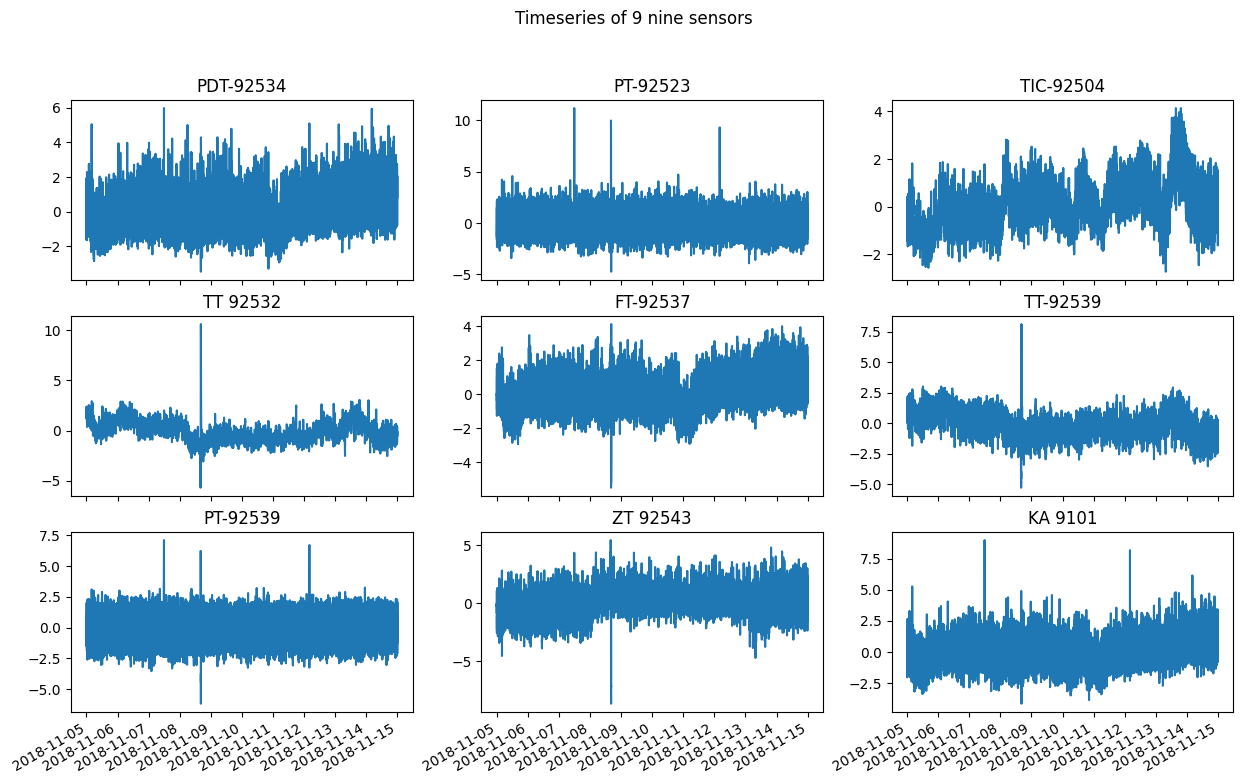

In [6]:
standard_df = standardize_dfs(dfs_dict)

plot_all_nine_sensors(dataframe=standard_df)

### Compile and plot histograms for each sensor

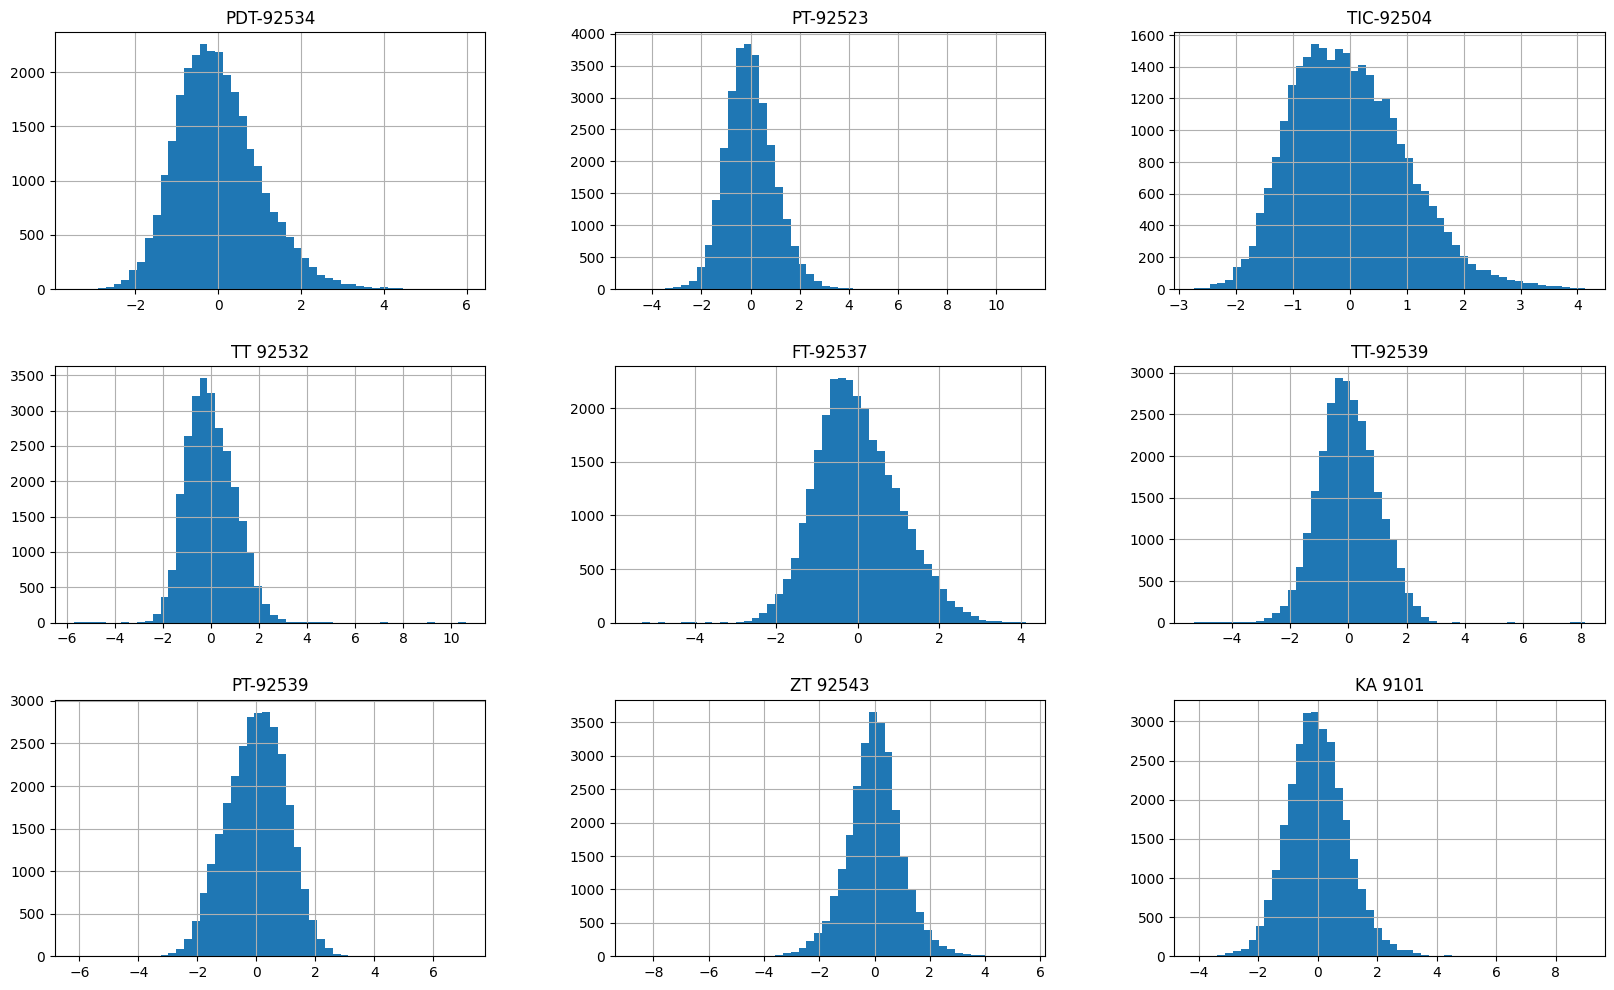

In [7]:
#Plot histograms
#Using standardized values
names = list(standard_df.keys())
fig, ax = plt.subplots(3, 3, figsize=(20, 12))
bins = 50

m=0
for i in range(3):
    for j in range(3):

        standard_df[names[m]].hist(bins = bins, ax=ax[i,j], figsize=(20, 18))
        ax[i,j].set_title(names[m])
        m+=1

plt.show()


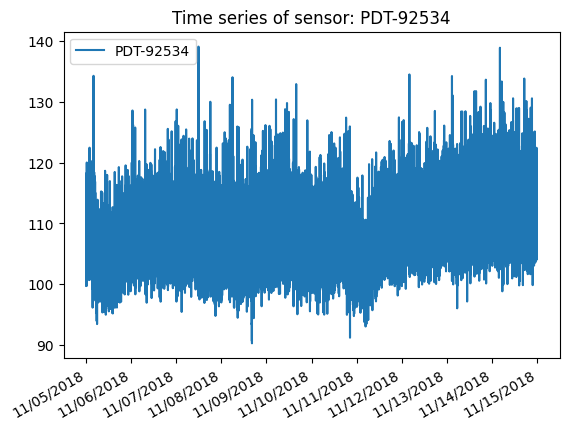

In [8]:
plot_sensor_data('PDT-92534', dfs_dict)

### Finding KL divergence by comparing histograms


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
[[0.0, inf, 0.09285417473770527, inf, inf, inf, inf, inf, inf], [inf, 0.0, 0.5540001206080062, inf, inf, inf, inf, inf, inf], [inf, inf, 0.0, inf, inf, inf, inf, inf, inf], [inf, inf, 0.49628320665616443, 0.0, inf, inf, inf, inf, inf], [inf, inf, 0.8376893116470262, inf, 0.0, inf, inf, inf, inf], [inf, inf, 0.33396599137904764, inf, inf, 0.0, inf, inf, inf], [inf, inf, 0.48646084322995475, inf, inf, inf, 0.0, inf, inf], [inf, inf, 1.4888126350128768, inf, inf, inf, inf, 0.0, inf], [inf, inf, 0.3573852207241478, 0.3275764527068086, inf, inf, inf, inf, 0.0]]


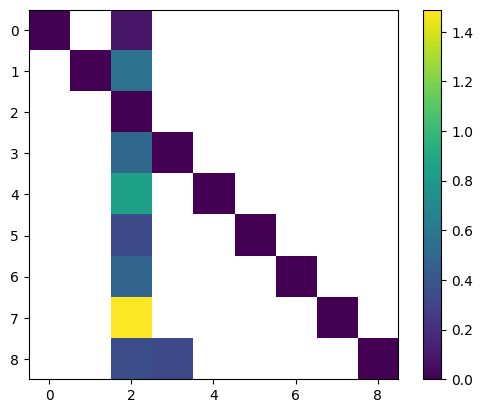

In [9]:
%pip install scipy
KL = []

i = 0
j = 0

for name, df in standard_df.items():
    row = []
    hist1 = np.histogram(df, bins=bins)[0]
    hist1 = hist1/sum(hist1)
    for name2, df2 in standard_df.items():
        hist2 = np.histogram(df2, bins=bins)[0]
        hist2 = hist2/sum(hist2)
        # print(f'H1: {type(hist1)}, H2: {type(hist2)}')
        row.append(entropy(hist1, hist2))
    KL.append(row)

print(KL)
im = plt.imshow(KL)
plt.colorbar(im)
plt.show()

### Finding KL divergence from mean and std

We assume that each sensors samples comes from a univariate normal distribution with mean $\mu$ and standard deviation $\sigma$, we can estimate $\mu$ and $\sigma$ from the sample date. We can thn find the KL divergence between 2 estimated distributions by the following formula

$$KL(\mathcal{N}_1(\mu_1, \sigma_1)||\mathcal{N}_2(\mu_2, \sigma_2)) = log(\frac{\sigma_2}{\sigma_1}) + \frac{\sigma_1^2 +(\mu_1-\mu_2)^2}{2 \sigma_2^2}-\frac{1}{2}$$

In [10]:
# Test the function
mu, sigma = 1, 2
mu2, sigma2 = 0, 2

print(f'Using mean and std directly: KL={KL_with_params(mu, sigma, mu2, sigma2)}')

Using mean and std directly: KL=0.125


Since this method assumes the mean and standard deviation comes from actual normal distributions, standardizing the samples would make all the sample distributions look identical. We therefore have to us unstandardized values with this KL divergence method. Since it's just estimates of mean and standard deviation, the computed KL divergence will not be the actual KL divergence between the sensors behavior, but rather the KL divergence between the sensors estimated source distributions.

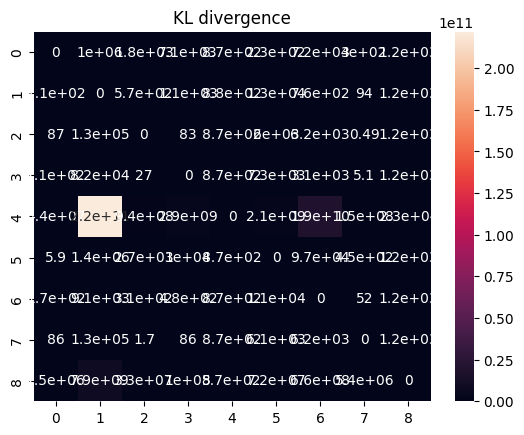

In [11]:
KL2 = kl_dfs(dfs_dict)
plot_kl(KL2)

### Correlation between sensors

           PDT-92534  PT-92523  TIC-92504  TT 92532  FT-92537  TT-92539  \
PDT-92534   1.000000  0.247361   0.369944  0.013008  0.895234 -0.220739   
PT-92523    0.247361  1.000000   0.063849 -0.130494 -0.191134 -0.138044   
TIC-92504   0.369944  0.063849   1.000000 -0.173375  0.355853 -0.401924   
TT 92532    0.013008 -0.130494  -0.173375  1.000000  0.115981  0.807176   
FT-92537    0.895234 -0.191134   0.355853  0.115981  1.000000 -0.139843   
TT-92539   -0.220739 -0.138044  -0.401924  0.807176 -0.139843  1.000000   
PT-92539   -0.078285  0.785645   0.085397 -0.125074 -0.404717 -0.079473   
ZT 92543    0.481864 -0.218031   0.364495 -0.371864  0.545722 -0.428288   
KA 9101     0.829531  0.630526   0.391673 -0.060142  0.577558 -0.252671   

           PT-92539  ZT 92543   KA 9101  
PDT-92534 -0.078285  0.481864  0.829531  
PT-92523   0.785645 -0.218031  0.630526  
TIC-92504  0.085397  0.364495  0.391673  
TT 92532  -0.125074 -0.371864 -0.060142  
FT-92537  -0.404717  0.545722  0.577558

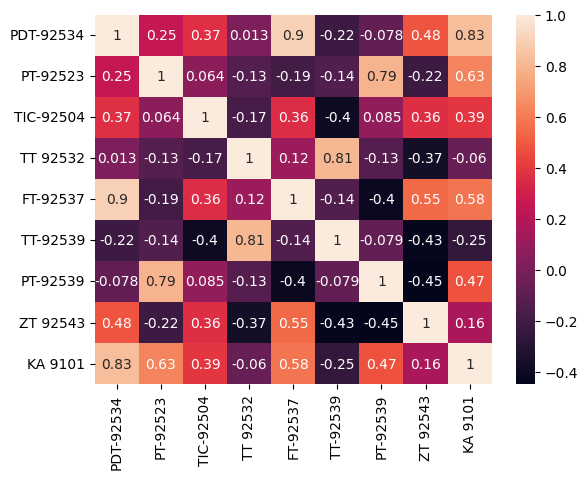

In [12]:
# %pip install jinja2
correlate_dfs(dfs_dict)

### Reshape all time series to same length

/home/fredrik/time_series_gan_project/functions.py:45: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  r_df = reshape_df(df).fillna(method='ffill')


Original shape: (28651, 1) Resampled shape: (28800, 1)
Original shape: (28650, 1) Resampled shape: (28800, 1)
Original shape: (28650, 1) Resampled shape: (28800, 1)
Original shape: (26149, 1) Resampled shape: (28800, 1)
Original shape: (28650, 1) Resampled shape: (28800, 1)
Original shape: (26951, 1) Resampled shape: (28800, 1)
Original shape: (28650, 1) Resampled shape: (28800, 1)
Original shape: (27733, 1) Resampled shape: (28800, 1)
Original shape: (28625, 1) Resampled shape: (28800, 1)
Reshaping done


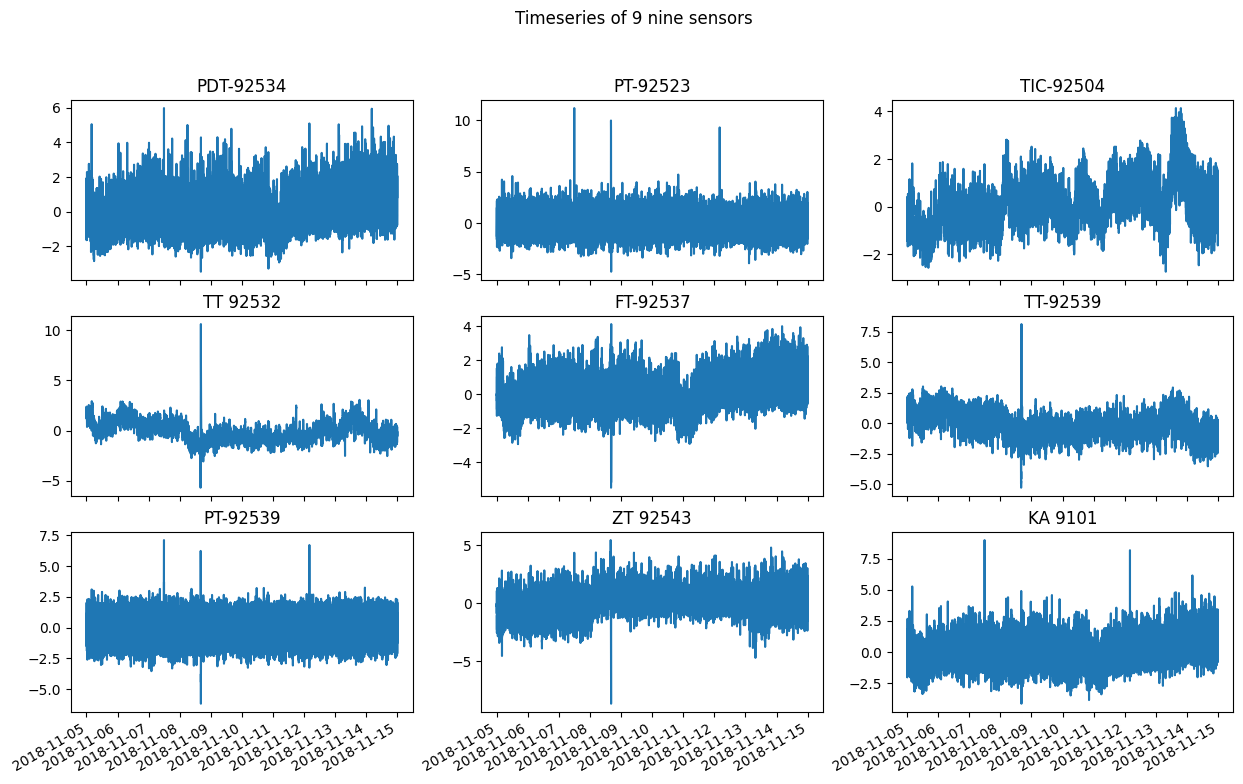

In [13]:
reshaped_dfs = reshape_dfs(standard_df)

plot_all_nine_sensors(reshaped_dfs)


## Checking for global trends in the data

/tmp/ipykernel_173/1121205051.py:16: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, index)


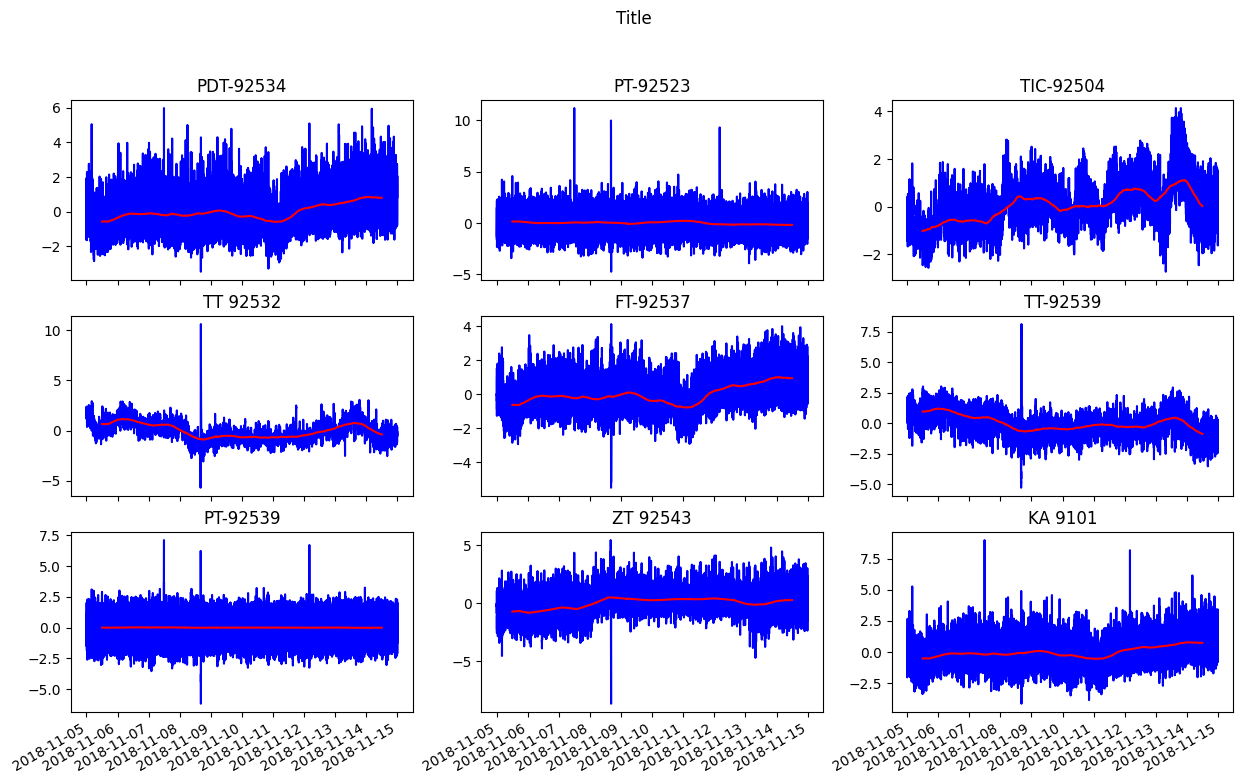

In [14]:
# %pip install statsmodels
import statsmodels.api as sm

title = 'Title'

plt.figure(figsize=(15, 9))
plt.suptitle(title)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
rows = 3
cols = 3
n = rows * cols
index = 1

for name, df in reshaped_dfs.items():
    plt.subplot(rows, cols, index)
    index += 1
    decomp = sm.tsa.seasonal_decompose(df, period = 2*60*24)
    plt.plot(df, c='blue')
    plt.plot(decomp.trend.index, decomp.trend, c='red')
    plt.gcf().autofmt_xdate()
    plt.title(name)
plt.show()

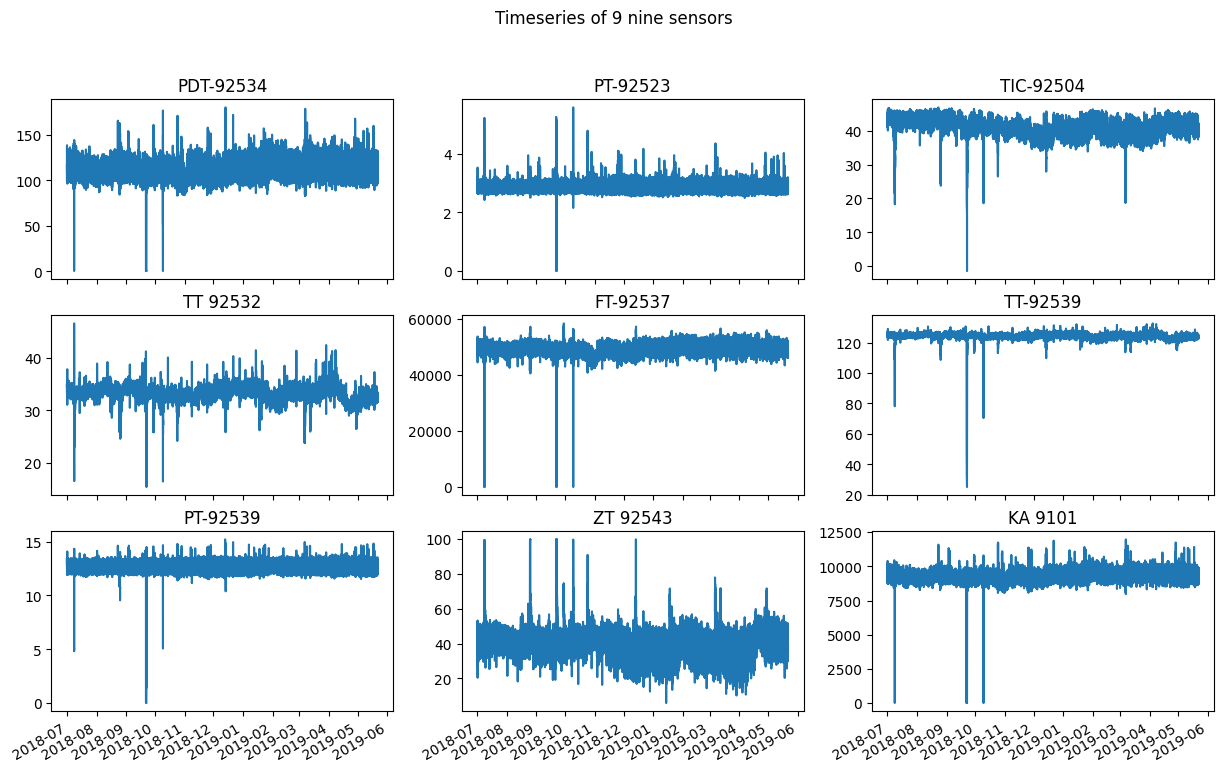

In [15]:
long_dfs_dict = {}

startdate = datetime(2018, 7, 1, tzinfo=timezone.utc)
enddate = datetime(2019, 5, 22, tzinfo=timezone.utc)
today = datetime.today()

for k, v in sensors.items():
    res = c.time_series.data.retrieve_dataframe(id=v, 
                                                start=startdate, 
                                                end=enddate, 
                                                column_names='id',
                                                aggregates=["average"],
                                                granularity="30s",)
    # Need to find a way to grab the unit of the time-series
    long_dfs_dict[k] = res

# plot_sensor_data('PDT-92534', dfs_dict)
plot_all_nine_sensors(long_dfs_dict)


/tmp/ipykernel_173/1761427744.py:14: FutureWarning: The 'method' keyword in DataFrame.replace is deprecated and will be removed in a future version.
  df = df.replace(to_replace=0, method='ffill')
/tmp/ipykernel_173/1761427744.py:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(rows, cols, index)


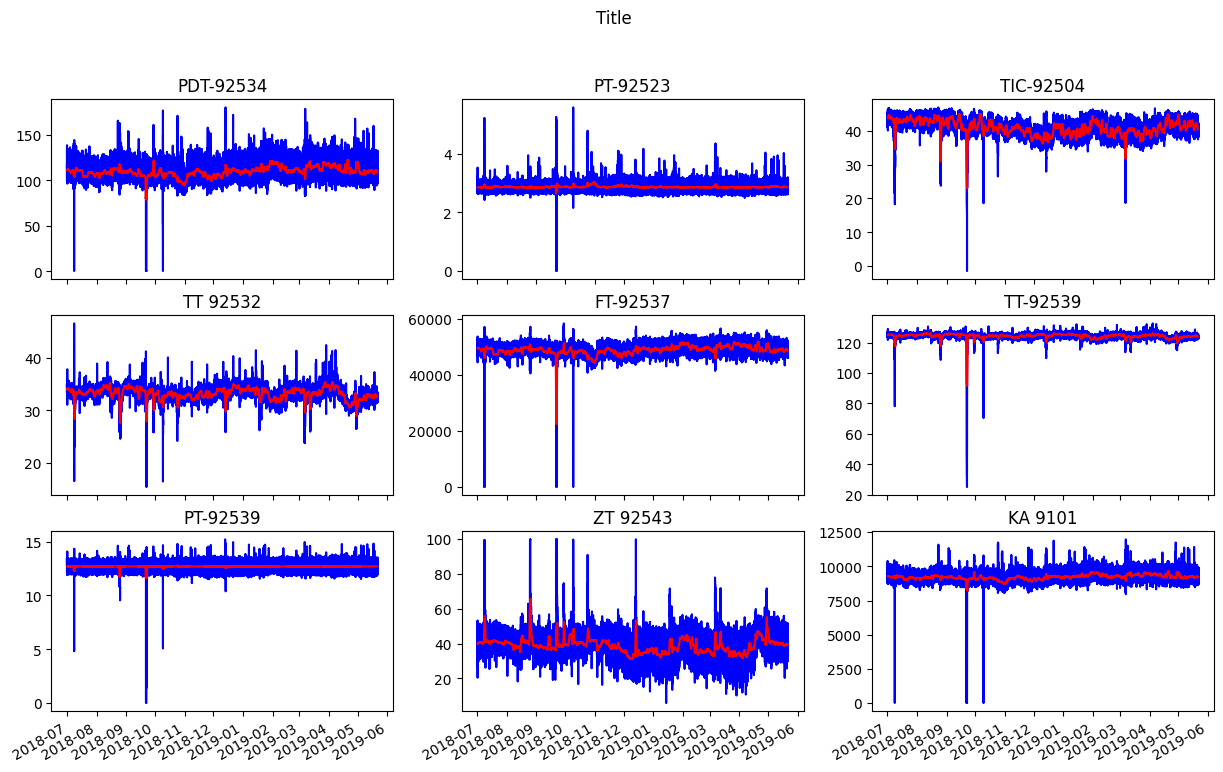

In [16]:
title = 'Title'


plt.figure(figsize=(15, 9))
plt.suptitle(title)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d/%m/%Y'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
rows = 3
cols = 3
n = rows * cols
index = 1

for name, df in long_dfs_dict.items():
    df = df.replace(to_replace=0, method='ffill')
    plt.subplot(rows, cols, index)
    index += 1
    decomp = sm.tsa.seasonal_decompose(df, period = 2*60*24)
    plt.plot(df, c='blue')
    plt.plot(decomp.trend.index, decomp.trend, c='red')
    plt.gcf().autofmt_xdate()
    plt.title(name)
plt.show()